# Speech to Text Using Whisper  <br>

A study of the automatic speech recognition model on Danish radio broadcasts <br>
<br>
Astrid Hansen <br>
EC Utbildning <br>
Data Science Project <br>
202410 <br>

Content <br>
* Audio EDA
* Audio Classification
* Text Preprocessing
* Creating a Dataset
* Test of Baseline Whisper Models
* Transcription with the Openai implementation of Whisper and Segment Analysis
* Transcription with Whisper-Large-v3-turbo Hugging Face Implementation
* Fine-tuning of the large-v3-turbo model
* Transcribing with the Fine-Tuned Large-v3-turbo model
* Evaluation of the Models

# Audio EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

# ignore future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# load audio file from P1
file_path = '/run/user/1000/gvfs/sftp:host=lucina.statsbiblioteket.dk,user=anastasia//home/anastasia/lfm/QA/4138467_osri_P1_19960603_0600-0800/4138467_osri_P1_19960603_0600-0800_16k.wav'
audio_data, sampling_rate = librosa.load(file_path, sr=None)

In [ ]:
# Below is the caractheristics for the audio file from P1_1996-06-03 06:00-08:00 that will serve as test data
# The audio is a bit over 2 hours long and are already the sample rate 16.000

print(audio_data[200000:200020])
print("Sample Rate:", sampling_rate)
print("Number of samples:", len(audio_data))
print("Duration:", len(audio_data) / sampling_rate, "seconds")
print("Duration in hours:", len(audio_data) / sampling_rate / 3600, "hours")
print("Data type:", audio_data.dtype)
print("Shape:", audio_data.shape)

[-3.6621094e-04 -3.3569336e-04 -3.3569336e-04 -4.2724609e-04
 -3.9672852e-04 -3.9672852e-04 -4.2724609e-04 -3.9672852e-04
 -4.8828125e-04 -5.4931641e-04 -4.8828125e-04 -4.2724609e-04
 -3.6621094e-04 -2.4414062e-04 -3.0517578e-05  1.2207031e-04
  3.3569336e-04  3.9672852e-04  5.1879883e-04  6.4086914e-04]
Sample Rate: 16000
Number of samples: 117134677
Duration: 7320.9173125 seconds
Duration in hours: 2.033588142361111 hours
Data type: float32
Shape: (117134677,)


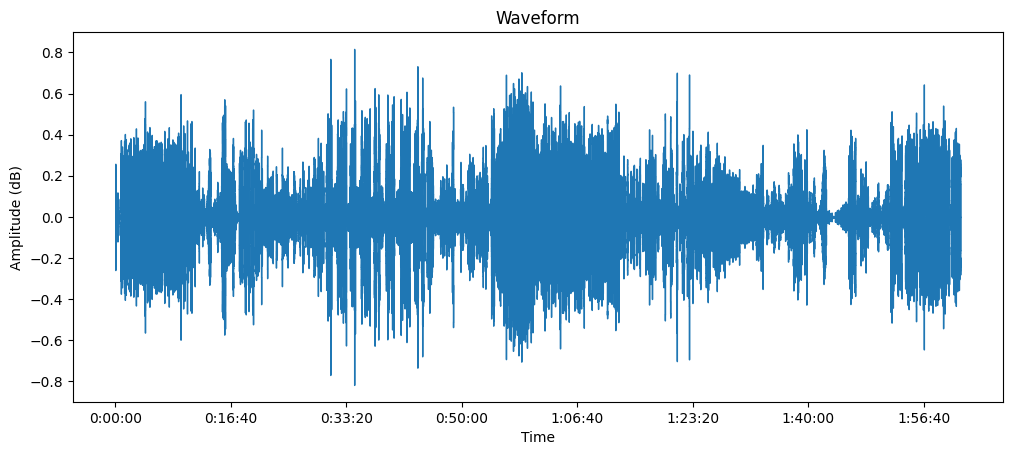

In [ ]:
# plot of the audio data in a waveform that shows the amplitude of the audio signal over time
plt.figure().set_figwidth(12)
librosa.display.waveshow(audio_data, sr=sampling_rate)
plt.title('Waveform')
plt.xlabel('Time')
plt.ylabel("Amplitude (dB)")
plt.show()

Text(0.5, 1.0, 'Frequency Spectrum')

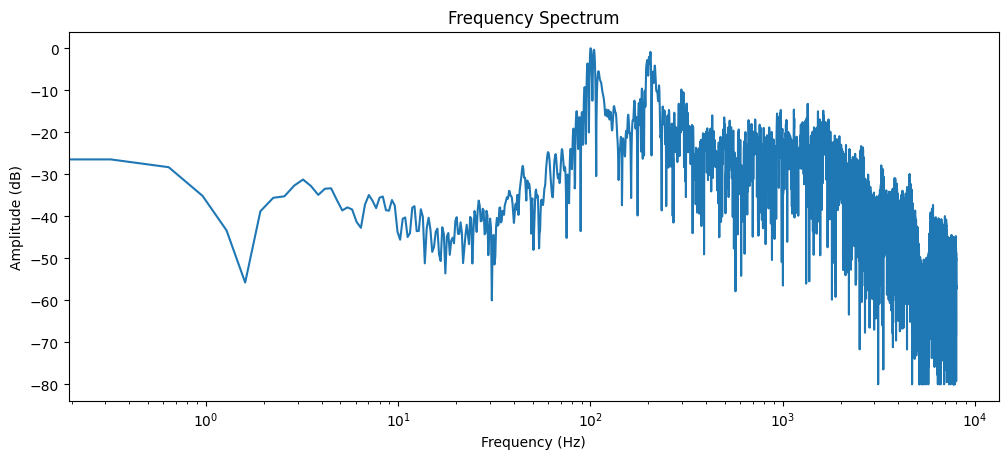

In [ ]:
# Below is a plot of the frequency spectrum that displays the frequencies and their amplitude in decibels at a fixed point in time.
# The frequencies between 1khz and 100 khz are the loudest and most of the frequencies are in the range just below 100 khz and a bit above
# which corresponds well with the human voice frequency range. 

dft_input = audio_data[:50000]

# calculate dft - discrete fourier transform
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")
plt.title("Frequency Spectrum")

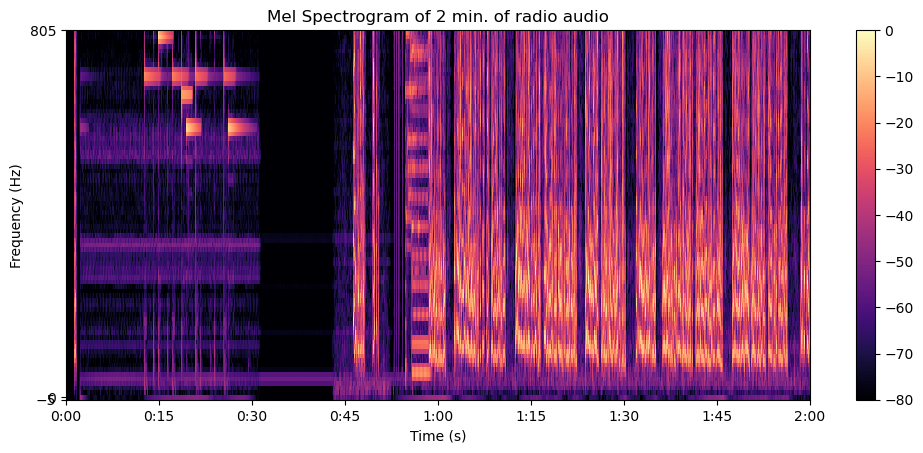

In [15]:
# Plot of the log-mel spectrogram of 2 minutes of the audio file.
# the plot visualizes the frequency and amplitude of the audio signal over time

# extract the first 2 minutes of the audio signal
audio_data_2min = audio_data[:2*60*sampling_rate]

S = librosa.feature.melspectrogram(y=audio_data_2min, sr=sampling_rate, n_mels=80, fmax=800)
S_dB = librosa.power_to_db(S, ref=np.max) # the amplitude values are transformed to a logarithmic scale. 

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=800)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Mel Spectrogram of 2 min. of radio audio")
plt.colorbar()

# AUDIO CLASSIFICATION <br>
Below is an investigation of the sounds files content. It is done via the use of a pretrained audio classification model from Hugging Face.
The classification will be done on both of the audio files - one from the channel P1 and one from the channel P3

In [15]:
import numpy as np
from transformers import AutoFeatureExtractor, ASTForAudioClassification
import torch
import librosa
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load the audio file from P1_1996-06-03 06:00-08:00
file_path = '/run/user/1000/gvfs/sftp:host=lucina.statsbiblioteket.dk,user=anastasia//home/anastasia/lfm/QA/4138467_osri_P1_19960603_0600-0800/4138467_osri_P1_19960603_0600-0800_16k.wav'
audio_data, sampling_rate = librosa.load(file_path, sr=None)

In [ ]:
# loading the pre-trained model and feature extractor from the Hugging Face Model Hub that will perform the audio classifications

feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

feature_extractor.num_mel_filters = 64 # mel filters=64 to insćrease speed and reduce memory usage and should be sufficient for spoken language audio 

model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

/home/asha/ds_project/ds_project/.conda/lib/python3.12/site-packages/transformers/audio_utils.py:297: UserWarning: At least one mel filter has all zero values. The value for `num_mel_filters` (128) may be set too high. Or, the value for `num_frequency_bins` (256) may be set too low.
  warnings.warn(


In [ ]:
# check the model and device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cpu


ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

In [ ]:
# Define a function to split the audio into smaller chunks and create a dataframe to store the results

def split_audio(audio_array, chunk_size, sampling_rate):
    num_chunks = len(audio_array) // (chunk_size * sampling_rate)
    chunks = [audio_array[i*chunk_size*sampling_rate : (i+1)*chunk_size*sampling_rate] for i in range(num_chunks)]
    return chunks

def format_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# instatiate chunk size and call the split audio function on the audio data from P1_1996-06-03 06:00-08:00
chunk_size = 5  # in seconds
audio_chunks = split_audio(audio_array, chunk_size, sampling_rate)

In [ ]:
# inspect the audio chunks
print(type(audio_chunks))
print(audio_chunks[0].shape)
print(audio_chunks[:2])


<class 'list'>
(80000,)
[array([ 0.        ,  0.        ,  0.        , ..., -0.0005188 ,
       -0.00057983, -0.00039673], dtype=float32), array([-0.00024414, -0.00018311, -0.00018311, ..., -0.00033569,
       -0.00027466, -0.00021362], dtype=float32)]


In [ ]:
# A loop that iterates over the audio chunks, processes them with the model, and stores the results in a dataframe
for chunk in audio_chunks:
    inputs = feature_extractor(
        chunk, 
        sampling_rate=sampling_rate, 
        return_tensors="pt"
    )

    with torch.no_grad():
        logits = model(**inputs).logits   # logits contains the raw output of the model

    predicted_class_ids = torch.argmax(logits, dim=-1).item() # find the index with the highest value. Item() converts it to a python number
    predicted_label = model.config.id2label[predicted_class_ids] # get the label corresponding to the index

    # print(f"{format_time(time)}: {predicted_label}")
    df = pd.concat([df, pd.DataFrame([[format_time(time),predicted_label]], columns=df.columns)], ignore_index=True) # can I get the audio chunks as well?
    time += chunk_size
    

In [6]:
df.head(10)

,Time,Label
0,00:00:00,Speech
1,00:00:05,Sine wave
2,00:00:10,Music
3,00:00:15,Music
4,00:00:20,Music
5,00:00:25,Ding-dong
6,00:00:30,Ding-dong
7,00:00:35,Silence
8,00:00:40,Silence
9,00:00:45,Speech


In [ ]:
# Save the audio classification results to a CSV file
df.to_csv('audio_classification_P1_19960603_0600-0800.csv', index=False)

# load the audio classification csv as df
df = pd.read_csv('/home/asha/ds_project/csv_files/audio_classification_P1_19960603_0600-0800.csv')

In [9]:
df.Label.value_counts()

Label
Music                      788
Speech                     511
Violin, fiddle              77
Opera                       49
Choir                       25
French horn                  5
Silence                      2
Ding-dong                    2
Brass instrument             2
Sine wave                    1
Trumpet                      1
Bowed string instrument      1
Name: count, dtype: int64

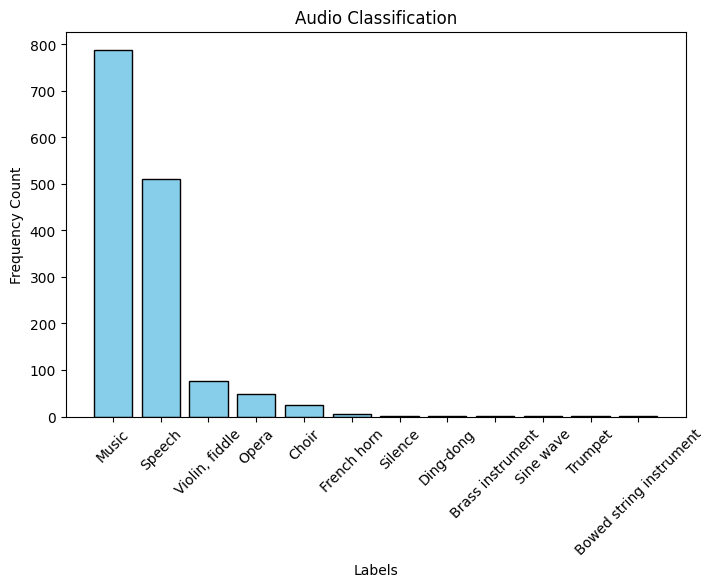

In [100]:
# plt the dataframe and counts of audio classes
value_counts = df['Label'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar(value_counts.index, value_counts, color='skyblue', edgecolor='black') #backgroundcolor='#f5f5f5')
plt.title('Audio Classification')
plt.xlabel('Labels')
plt.ylabel('Frequency Count')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Audio Classification of the Audio file from P3 
file_path = '/run/user/1000/gvfs/sftp:host=lucina.statsbiblioteket.dk,user=anastasia/home/anastasia/lfm/QA/5326480_osri_P3_20040808_0400-0600/5326480_osri_P3_20040808_0400-0600_16k.wav'
audio_data, sampling_rate = librosa.load(file_path, sr=None)

In [ ]:
# split audio into chunks
audio_chunks = split_audio(audio_data, chunk_size, sampling_rate)

print(type(audio_chunks))
print(audio_chunks[0].shape)
print(audio_chunks[:2])

<class 'list'>
(80000,)
[array([ 0.        ,  0.        ,  0.        , ...,  0.00283813,
       -0.00561523, -0.01425171], dtype=float32), array([-0.01895142, -0.01724243, -0.01113892, ...,  0.0249939 ,
        0.0249939 ,  0.02682495], dtype=float32)]


In [ ]:
# process the audio chunks with the model and store the results in a dataframe
for chunk in audio_chunks:
    inputs = feature_extractor(
        chunk, 
        sampling_rate=sampling_rate, 
        return_tensors="pt"
    )

    with torch.no_grad():
        logits = model(**inputs).logits   # logits contains the raw output of the model

    predicted_class_ids = torch.argmax(logits, dim=-1).item() # find the index with the highest value. Item() converts it to a python number
    predicted_label = model.config.id2label[predicted_class_ids] # get the label corresponding to the index

    # print(f"{format_time(time)}: {predicted_label}")
    df = pd.concat([df, pd.DataFrame([[format_time(time),predicted_label]], columns=df.columns)], ignore_index=True) # can I get the audio chunks as well?
    time += chunk_size


In [ ]:
# save the audio classification results to a CSV file
df = df.to_csv('audio_classification_P3_20040808_0400-0600.csv', index=False)

# load the audio classification csv as df
df = pd.read_csv('/home/asha/ds_project/csv_files/audio_classification_P3_20040808_0400-0600.csv')
df.head(10)

,Time,Label
0,00:00:00,Music
1,00:00:05,Music
2,00:00:10,Music
3,00:00:15,Music
4,00:00:20,Music
5,00:00:25,Music
6,00:00:30,Music
7,00:00:35,Music
8,00:00:40,Music
9,00:00:45,Music


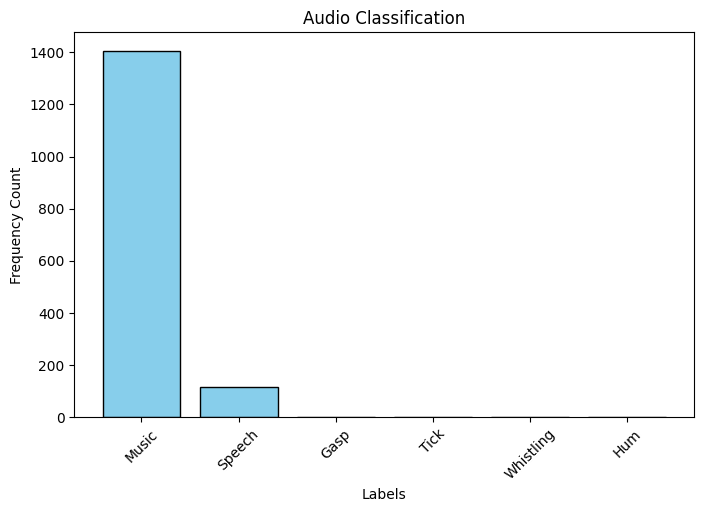

In [103]:
# plt the dataframe and counts of audio classes
value_counts = df['Label'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar(value_counts.index, value_counts, color='skyblue', edgecolor='black') #backgroundcolor='#f5f5f5')
plt.title('Audio Classification')
plt.xlabel('Labels')
plt.ylabel('Frequency Count')
plt.xticks(rotation=45)
plt.show()


In [16]:
# Prepare for plotting the two dataframes
# import csv file as df
df_P1 = pd.read_csv('/home/asha/ds_project/csv_files/audio_classification_P1_19960603_0600-0800.csv')
df_P3 = pd.read_csv('/home/asha/ds_project/csv_files/audio_classification_P3_20040808_0400-0600.csv')

# create a new column where the labels with value counts below 5 are labeled as 'other'
df_P1['Label_new'] = df_P1['Label'].apply(lambda x: 'other' if df_P1['Label'].value_counts()[x] <= 5 else x)
print(df_P1.Label_new.value_counts())

print()
# create a new column where the labels with value counts below 5 are labeled as 'other'
df_P3['Label_new'] = df_P3['Label'].apply(lambda x: 'other' if df_P3['Label'].value_counts()[x] <= 5 else x)
print(df_P3.Label_new.value_counts())

Label_new
Music             788
Speech            511
Violin, fiddle     77
Opera              49
Choir              25
other              14
Name: count, dtype: int64

Label_new
Music     1406
Speech     116
other        6
Name: count, dtype: int64


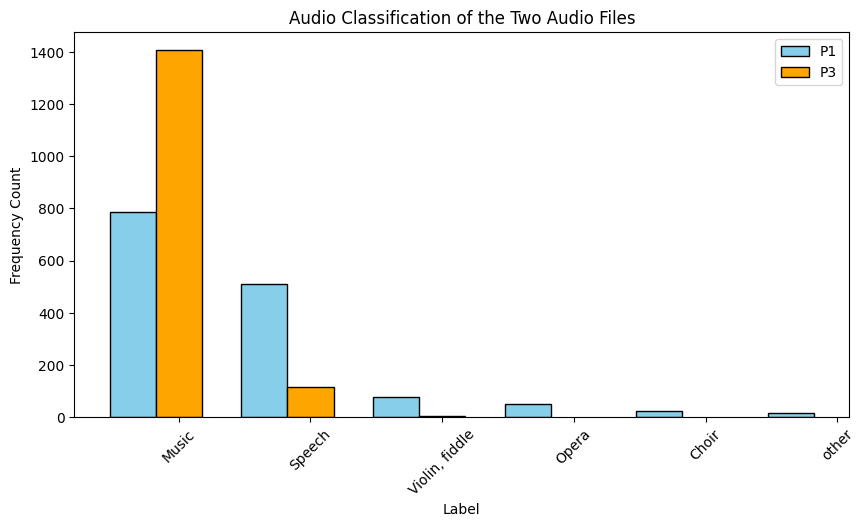

<Figure size 640x480 with 0 Axes>

In [17]:
# count the values of the labels in the dataframe df
value_counts_P1 = df_P1['Label_new'].value_counts()
value_counts_P3 = df_P3['Label_new'].value_counts()

# Bar plot of the two audio files
plt.subplots(figsize=(10, 5))

# Create an array of indices for the x-axis and set bar_width
indices_P1 = np.arange(len(value_counts_P1.index))
indices_P3 = np.arange(len(value_counts_P3.index))
bar_width = 0.35

# Plot the bars
plt.bar(indices_P1, value_counts_P1, color='skyblue', edgecolor='black', width=bar_width, label='P1') 
plt.bar(indices_P3 + bar_width, value_counts_P3, color='orange', edgecolor='black', width=bar_width, label='P3')

# Adding labels and title
plt.xlabel('Label')
plt.ylabel('Frequency Count')
plt.title('Audio Classification of the Two Audio Files')
# Set labels on the x axis from df_P1['Label_new]
plt.xticks(indices_P1 + bar_width, value_counts_P1.index, rotation=45)
plt.legend()

# Show the plot
plt.show()
plt.savefig('audio_classification.png')

# Text Preprocessing <br>
First we process the excel file with transcriptions and comments for the P1 audio file. 
After slight cleaning and processing then the text is saved as a txt file and will serve as the ground truth for the evaluation of the models. 
A additional txt file is created based on the first 5 minutes of sound. This will serve as a small sample for testing purposes.

In [ ]:
import pandas as pd
import re
from pydub import AudioSegment

In [ ]:
# load the excel file with the transcribed text and timestamps
file = '/home/asha/ds_project/csv_files/csv_files/AnneSofie-retter-4138467_osri_P1_19960603_0600-0800_16k_whisper-large-v3.xlsx'
text = pd.read_excel(file)
text.head()

,index,start,end,text,Anne Sofies kommentarer,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,Jeg har nogle tanker. Danske tekster af Jesper...,Intro,NaN,NaN,NaN
1,1.0,0.00,48.02,"Godmorgen, her er Danmarks Radioprogram 1.",Tale kommer ved 00.45.00,NaN,NaN,NaN
2,2.0,49.04,50.01,Klokken er seks.,NaN,NaN,NaN,NaN
3,3.0,58.03,61.02,"Godmorgen, her er Radioavisen. Det er mandag d...",NaN,NaN,NaN,NaN
4,4.0,61.02,62.03,NaN,"Gentager ""Den 3. juni""",NaN,NaN,NaN


In [5]:
text.tail()

,index,start,end,text,Anne Sofies kommentarer,Unnamed: 5,Unnamed: 6,Unnamed: 7
748,748.0,7299.00,7302.07,Vejrudsigten i Nordvestjylland vekslende skydæ...,NaN,NaN,NaN,NaN
749,749.0,7303.00,7304.05,fra i eftermiddag måske en enkelt byge.,NaN,NaN,NaN,NaN
750,750.0,7304.01,7311.06,I resten af landet forløbigt skyet og stedvis ...,NaN,NaN,NaN,NaN
751,751.0,7313.00,7315.09,"Hovedstaden, ambassaden, tjenesteboligen.",NaN,NaN,NaN,NaN
752,752.0,7316.05,7318.08,"En er for lille, men ingen er for stor.",NaN,NaN,NaN,NaN


In [6]:
text.shape

(753, 8)

In [7]:
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    752 non-null    float64
 1   start                    752 non-null    float64
 2   end                      752 non-null    float64
 3   text                     745 non-null    object 
 4   Anne Sofies kommentarer  21 non-null     object 
 5   Unnamed: 5               0 non-null      float64
 6   Unnamed: 6               0 non-null      float64
 7   Unnamed: 7               2 non-null      object 
dtypes: float64(5), object(3)
memory usage: 47.2+ KB


In [ ]:
# remove the first row of the dataframe since the text is not present in the audio file but is a sort of header for the transcription
text = text[1:]
text.head()

,index,start,end,text,Anne Sofies kommentarer,Unnamed: 5,Unnamed: 6,Unnamed: 7
1,1.0,0.00,48.02,"Godmorgen, her er Danmarks Radioprogram 1.",Tale kommer ved 00.45.00,NaN,NaN,NaN
2,2.0,49.04,50.01,Klokken er seks.,NaN,NaN,NaN,NaN
3,3.0,58.03,61.02,"Godmorgen, her er Radioavisen. Det er mandag d...",NaN,NaN,NaN,NaN
4,4.0,61.02,62.03,NaN,"Gentager ""Den 3. juni""",NaN,NaN,NaN
5,5.0,64.04,64.04,"Den tyske nationalbank er imod,",NaN,NaN,NaN,NaN


In [9]:
# create a list  variable out of the text_pd dataframe with the values from the text columns seperated with a space
text_list = text['text'].tolist()
text_list[:10]

['Godmorgen, her er Danmarks Radioprogram 1.',
 'Klokken er seks.',
 'Godmorgen, her er Radioavisen. Det er mandag den 3. juni.',
 nan,
 'Den tyske nationalbank er imod,',
 'at Danmark bliver rykket op mellem de lande,',
 'der opfylder Maastricht-kriterierne for at være med i den økonomiske union.',
 'De britiske myndigheders bestræbelser',
 'for at udrydde kogalskab er tilsyneladende slået fejl.',
 'Antallet af sygdomstilfælde er kun faldet meget beskedent,']

In [10]:
# Convert all values to strings and then join
text_str = " ".join(str(x) for x in text_list)
type(text_str)

str

In [ ]:
# remove all instances that looks like this ...opera... and everything in parenthesis since they are comments from the transcriber
cleaned_text = re.sub(r'\(.*?\)', '', text_str)

cleaned_text = cleaned_text.replace("...opera...", "")

In [12]:
# save the transcription to a file
with open("text_P1_19960603_0600-0800.txt", "w") as f:
    f.write(cleaned_text)

In [ ]:
# Extract the first 5 minutes of the text file for testing purposes
first_5min = 5*60
mask = (text['end'] <= first_5min) | (text['end'].isna())

# Extract the filtered DataFrame
filtered_text = text[mask]

filtered_text

,index,start,end,text,Anne Sofies kommentarer,Unnamed: 5,Unnamed: 6,Unnamed: 7
1,1.0,0.00,48.02,"Godmorgen, her er Danmarks Radioprogram 1.",Tale kommer ved 00.45.00,NaN,NaN,NaN
2,2.0,49.04,50.01,Klokken er seks.,NaN,NaN,NaN,NaN
3,3.0,58.03,61.02,"Godmorgen, her er Radioavisen. Det er mandag d...",NaN,NaN,NaN,NaN
4,4.0,61.02,62.03,NaN,"Gentager ""Den 3. juni""",NaN,NaN,NaN
5,5.0,64.04,64.04,"Den tyske nationalbank er imod,",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
64,64.0,277.00,281.04,"Hvornår skal det træde i kraft, og hvad kommer...",NaN,NaN,NaN,NaN
65,65.0,281.10,285.05,Det skal allerede træde i kraft senest fra 1. ...,NaN,NaN,NaN,NaN
66,66.0,286.00,289.07,og for dansk landbrug så taler vi om investeri...,NaN,NaN,NaN,NaN
67,67.0,291.03,294.07,Det sagde altså landbrugsminister Henrik Dam C...,NaN,NaN,NaN,NaN


In [14]:
text_5min = filtered_text['text'].tolist()
text_5min[:10]

['Godmorgen, her er Danmarks Radioprogram 1.',
 'Klokken er seks.',
 'Godmorgen, her er Radioavisen. Det er mandag den 3. juni.',
 nan,
 'Den tyske nationalbank er imod,',
 'at Danmark bliver rykket op mellem de lande,',
 'der opfylder Maastricht-kriterierne for at være med i den økonomiske union.',
 'De britiske myndigheders bestræbelser',
 'for at udrydde kogalskab er tilsyneladende slået fejl.',
 'Antallet af sygdomstilfælde er kun faldet meget beskedent,']

In [ ]:
# save text_5min to a file
text_5min_str = " ".join(str(x) for x in text_5min)


In [ ]:
# save the text_5min to a text file
with open('text_P1_19960603_0600-0800_5min.txt', 'w') as f:
    f.write(text_5min_str)

In [2]:
# load the audio file from P1_1996-06-03 06:00-08:00
file_path = '/home/asha/ds_project/4138467_osri_P1_19960603_0600-0800_16k.wav'
audio_data, sampling_rate = librosa.load(file_path, sr=None)

In [ ]:
# Extract the first 5 minutes of the audio file for testing purposes
audio = AudioSegment.from_file("/home/asha/ds_project/4138467_osri_P1_19960603_0600-0800_16k.wav")

# extrac the first 5 minutes of the audio file
first_5min = 5*60*1000
audio_5min = audio[:first_5min]

# export the audio file
audio_5min.export("audio_P1_5min.mp3", format="mp3")

<_io.BufferedRandom name='audio_P1_5min.mp3'>

# Creating a Dataset <br>
The CSV file with the transcript for the audio file from P3 will be processed and a train and val text file will be created. The train text are based on the first 20 rows of text and the val text are based on the next 13 rows of text. 

In [8]:
import os
from pydub import AudioSegment
import pandas as pd
from datasets import DatasetDict, Dataset

In [10]:
# load the csv file with the manual transcription and time stamps of the audio file from P3
file = '/home/asha/ds_project/csv_files/Simone_Rettet_5326480_osri_P3_20040808_0400-0600_whisper-large-v3.xlsx'
text = pd.read_excel(file, index_col=0)
text.head(40)

,start,end,text,Simone kommentare - det grønne = nyheder
index,,,,
1,0.00,91.01,Danske officeraspiranter udsættes i løbet af d...,starter ud med en sang med Mary Chapin Carpent...
2,91.01,96.03,"i en stresset situation, siger pensioneret gen...","generelle problemer med ""Æ, Ø, Å"""
3,97.00,103.08,"Major Carsten Hasenfuss, der underviser i afhø...",NaN
4,103.08,105.09,"hvad de må udføre på andre under afhøring,",NaN
5,106.03,110.05,og hvad de selv risikerer at blive udsat for i...,NaN
6,111.06,117.08,Det britiske militærpoliti undersøger yderlige...,NaN
7,118.02,126.02,Dermed undersøger myndighederne nu i alt 94 sa...,NaN
8,127.00,131.04,"Der er mistanke om, at fanger er blevet skudt,...",NaN
9,131.09,136.02,"samt anden ulovlig behandling, mens de har vær...",NaN


In [ ]:
# load audio file from P3
audio_path = '/run/user/1000/gvfs/sftp:host=lucina.statsbiblioteket.dk,user=anastasia/home/anastasia/lfm/QA/5326480_osri_P3_20040808_0400-0600/5326480_osri_P3_20040808_0400-0600_16k.wav'
audio = AudioSegment.from_file(audio_path)


In [11]:
# create a new dataframe with index ids upp untill index 33
text_sample = text.iloc[:33]
text_sample

,start,end,text,Simone kommentare - det grønne = nyheder
index,,,,
1,0.00,91.01,Danske officeraspiranter udsættes i løbet af d...,starter ud med en sang med Mary Chapin Carpent...
2,91.01,96.03,"i en stresset situation, siger pensioneret gen...","generelle problemer med ""Æ, Ø, Å"""
3,97.00,103.08,"Major Carsten Hasenfuss, der underviser i afhø...",NaN
4,103.08,105.09,"hvad de må udføre på andre under afhøring,",NaN
5,106.03,110.05,og hvad de selv risikerer at blive udsat for i...,NaN
6,111.06,117.08,Det britiske militærpoliti undersøger yderlige...,NaN
7,118.02,126.02,Dermed undersøger myndighederne nu i alt 94 sa...,NaN
8,127.00,131.04,"Der er mistanke om, at fanger er blevet skudt,...",NaN
9,131.09,136.02,"samt anden ulovlig behandling, mens de har vær...",NaN


In [13]:
# change the start time at index 1 to 69.00
text_sample.at[1, 'start'] = 69.00
text_sample

,start,end,text,Simone kommentare - det grønne = nyheder
index,,,,
1,69.00,91.01,Danske officeraspiranter udsættes i løbet af d...,starter ud med en sang med Mary Chapin Carpent...
2,91.01,96.03,"i en stresset situation, siger pensioneret gen...","generelle problemer med ""Æ, Ø, Å"""
3,97.00,103.08,"Major Carsten Hasenfuss, der underviser i afhø...",NaN
4,103.08,105.09,"hvad de må udføre på andre under afhøring,",NaN
5,106.03,110.05,og hvad de selv risikerer at blive udsat for i...,NaN
6,111.06,117.08,Det britiske militærpoliti undersøger yderlige...,NaN
7,118.02,126.02,Dermed undersøger myndighederne nu i alt 94 sa...,NaN
8,127.00,131.04,"Der er mistanke om, at fanger er blevet skudt,...",NaN
9,131.09,136.02,"samt anden ulovlig behandling, mens de har vær...",NaN


In [ ]:
# Create a new audio file with the seconds range from 69 seconds to 287.07 seconds
start_time = 69 * 1000
end_time = 241.04 * 1000
audio_sample = audio[start_time:end_time]

# save the audio_sample as a new audio file
audio_sample.export("/home/asha/ds_project/audio_sample.wav", format="wav")

<_io.BufferedRandom name='/home/asha/ds_project/audio_sample.wav'>

In [32]:
# inspect the duration of the audio_sample
print(audio_sample.duration_seconds)
# duration in minutes
print(audio_sample.duration_seconds / 60)

172.04
2.8673333333333333


In [33]:
# directory to save audio chunks
output_dir = '/home/asha/ds_project/radio_dataset/audio_chunks'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# iterate over the text_sample dataframe and extract the audio chunks based on the start and end times
for i, row in text_sample.iterrows():
    start_time = row['start']
    end_time = row['end']
    text = row['text']
    
    # extract audio chunk
    start_time_ms = start_time * 1000
    end_time_ms = end_time * 1000
    chunk = audio[start_time_ms:end_time_ms]
    
    # save audio chunk
    output_file = os.path.join(output_dir, f'chunk_{i}.wav')
    chunk.export(output_file, format='wav')
    
    # save text
    text_file = os.path.join(output_dir, f'chunk_{i}.txt')
    with open(text_file, 'w') as f:
        f.write(text)

In [41]:
# prepare data for a tsv file
data = []
for i, row in text_sample.iterrows():
    start_time = row['start']
    end_time = row['end']
    text = row['text']
    data.append([f'chunk_{i}.wav', start_time, end_time, text])


In [42]:
data

[['chunk_0.wav',
  69.0,
  91.01,
  'Danske officeraspiranter udsættes i løbet af deres uddannelse for så hårde afhøringsmetoder, at de kan have svært ved at finde ud af om de må bruge de samme metoder under virkelige fangerafhøringer, skriver Berlingske Tidende. Jeg er bange for, at tingene flyder sammen, så aspiranterne ikke kan skille træning og virkelig fra hinanden'],
 ['chunk_1.wav',
  91.01,
  96.03,
  'i en stresset situation, siger pensioneret generalløjtnant KGH Hillingsø¸.'],
 ['chunk_2.wav',
  97.0,
  103.08,
  'Major Carsten Hasenfuss, der underviser i afhøringsteknik, siger, at aspiranterne godt kan skelne mellem,'],
 ['chunk_3.wav', 103.08, 105.09, 'hvad de må udføre på andre under afhøring,'],
 ['chunk_4.wav',
  106.03,
  110.05,
  'og hvad de selv risikerer at blive udsat for i virkelighedens verden.'],
 ['chunk_5.wav',
  111.06,
  117.08,
  'Det britiske militærpoliti undersøger yderligere 48 mistænkelige dødsfald i Irak.'],
 ['chunk_6.wav',
  118.02,
  126.02,
  'Der

In [ ]:
# Create a DataFrame
df = pd.DataFrame(data)

In [75]:
df.head(10)

,0,1,2,3
0,chunk_0.wav,69.00,91.01,Danske officeraspiranter udsættes i løbet af d...
1,chunk_1.wav,91.01,96.03,"i en stresset situation, siger pensioneret gen..."
2,chunk_2.wav,97.00,103.08,"Major Carsten Hasenfuss, der underviser i afhø..."
3,chunk_3.wav,103.08,105.09,"hvad de må udføre på andre under afhøring,"
4,chunk_4.wav,106.03,110.05,og hvad de selv risikerer at blive udsat for i...
5,chunk_5.wav,111.06,117.08,Det britiske militærpoliti undersøger yderlige...
6,chunk_6.wav,118.02,126.02,Dermed undersøger myndighederne nu i alt 94 sa...
7,chunk_7.wav,127.00,131.04,"Der er mistanke om, at fanger er blevet skudt,..."
8,chunk_8.wav,131.09,136.02,"samt anden ulovlig behandling, mens de har vær..."
9,chunk_9.wav,136.01,138.06,skriver avisen Independent i dag.


In [78]:
# change the column names in the dataframe
df.columns = ['audio', 'start', 'end', 'text']
df.head(10)

,audio,start,end,text
0,chunk_0.wav,69.00,91.01,Danske officeraspiranter udsættes i løbet af d...
1,chunk_1.wav,91.01,96.03,"i en stresset situation, siger pensioneret gen..."
2,chunk_2.wav,97.00,103.08,"Major Carsten Hasenfuss, der underviser i afhø..."
3,chunk_3.wav,103.08,105.09,"hvad de må udføre på andre under afhøring,"
4,chunk_4.wav,106.03,110.05,og hvad de selv risikerer at blive udsat for i...
5,chunk_5.wav,111.06,117.08,Det britiske militærpoliti undersøger yderlige...
6,chunk_6.wav,118.02,126.02,Dermed undersøger myndighederne nu i alt 94 sa...
7,chunk_7.wav,127.00,131.04,"Der er mistanke om, at fanger er blevet skudt,..."
8,chunk_8.wav,131.09,136.02,"samt anden ulovlig behandling, mens de har vær..."
9,chunk_9.wav,136.01,138.06,skriver avisen Independent i dag.


In [79]:
# Save to TSV file
df.to_csv('/home/asha/ds_project/radio_dataset/dataset.tsv', sep='\t', index=False)

In [80]:
df.shape

(33, 4)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   audio   33 non-null     object 
 1   start   33 non-null     float64
 2   end     33 non-null     float64
 3   text    33 non-null     object 
dtypes: float64(2), object(2)
memory usage: 1.2+ KB


In [ ]:
# divide the df into a train and a val set where train contains the first 20 indexes and test contains the rest
train = df.iloc[:20]
val = df.iloc[20:]

train.shape, val.shape

((20, 4), (13, 4))

In [83]:
train

,audio,start,end,text
0,chunk_0.wav,69.00,91.01,Danske officeraspiranter udsættes i løbet af d...
1,chunk_1.wav,91.01,96.03,"i en stresset situation, siger pensioneret gen..."
2,chunk_2.wav,97.00,103.08,"Major Carsten Hasenfuss, der underviser i afhø..."
3,chunk_3.wav,103.08,105.09,"hvad de må udføre på andre under afhøring,"
4,chunk_4.wav,106.03,110.05,og hvad de selv risikerer at blive udsat for i...
5,chunk_5.wav,111.06,117.08,Det britiske militærpoliti undersøger yderlige...
6,chunk_6.wav,118.02,126.02,Dermed undersøger myndighederne nu i alt 94 sa...
7,chunk_7.wav,127.00,131.04,"Der er mistanke om, at fanger er blevet skudt,..."
8,chunk_8.wav,131.09,136.02,"samt anden ulovlig behandling, mens de har vær..."
9,chunk_9.wav,136.01,138.06,skriver avisen Independent i dag.


In [84]:
val

,audio,start,end,text
20,chunk_20.wav,200.01,205.08,De høje priser får skoleledere til at kritiser...
21,chunk_21.wav,205.08,207.09,"administreres af Mejeriforeningen,"
22,chunk_22.wav,208.04,209.10,som er totalt domineret
23,chunk_23.wav,209.10,211.04,af Arla-repræsentanter.
24,chunk_24.wav,212.00,214.00,Sammenlignet med en liter mælk
25,chunk_25.wav,214.00,216.02,i et supermarked koster skolemælken
26,chunk_26.wav,216.02,217.00,cirka det dobbelte.
27,chunk_27.wav,217.08,219.09,Men vi sørger for at få mælken ud til skolerne.
28,chunk_28.wav,220.03,222.00,"Det kan man ikke holde op mod,"
29,chunk_29.wav,222.01,224.01,hvad en hel liter mælk koster


In [85]:
# Save to TSV file
train.to_csv('/home/asha/ds_project/radio_dataset/dataset_train.tsv', sep='\t', index=False)
val.to_csv('/home/asha/ds_project/radio_dataset/dataset_val.tsv', sep='\t', index=False)

In [86]:
# create a dataset dict with train and val datasets
dataset_dict = DatasetDict({
    'train': Dataset.from_pandas(train),
    'val': Dataset.from_pandas(val)
})

In [87]:
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['audio', 'start', 'end', 'text'],
        num_rows: 20
    })
    val: Dataset({
        features: ['audio', 'start', 'end', 'text'],
        num_rows: 13
    })
})


In [ ]:
# save the dataset_dict as a tsv file
dataset_dict.save_to_disk('/home/asha/ds_project/radio_dataset/dataset_dict.tsv')

In [89]:
# load the dataset_dict
dataset_dict = DatasetDict.load_from_disk('/home/asha/ds_project/radio_dataset/dataset_dict.tsv')
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['audio', 'start', 'end', 'text'],
        num_rows: 20
    })
    val: Dataset({
        features: ['audio', 'start', 'end', 'text'],
        num_rows: 13
    })
})

In [90]:
dataset_dict['train'][0]

{'audio': 'chunk_0.wav',
 'start': 69.0,
 'end': 91.01,
 'text': 'Danske officeraspiranter udsættes i løbet af deres uddannelse for så hårde afhøringsmetoder, at de kan have svært ved at finde ud af om de må bruge de samme metoder under virkelige fangerafhøringer, skriver Berlingske Tidende. Jeg er bange for, at tingene flyder sammen, så aspiranterne ikke kan skille træning og virkelig fra hinanden'}

# Test of Baseline Whisper Models <br>
The following code piece performs a test of the baseline models on a 5 minute extract of the audio file from P1 and corresponding transcription


In [ ]:
import whisper
import time
import pandas as pd
import librosa
import jiwer
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the 5 min transcription file from P!_19960603_0600-0800
with open('/home/asha/ds_project/texts/text_P1_19960603_0600-0800_5min.txt', 'r') as f:
    reference = f.readlines()


In [ ]:
# load the 5 minutes audio file from the audio file P1_19960603_0600-0800
file_path = '/home/asha/ds_project/audio/audio_P1_5min.mp3'
audio_data, sampling_rate = librosa.load(file_path, sr=None)

In [ ]:
# Create a list with models to test
models = ['tiny', 'base', 'small', 'medium', 'large-v2', 'large-v3', 'large-v3-turbo']

In [ ]:
# Initialize an empty list to store results
results = []

# Loop through each model and calculate the WER score and return the transcription time
for model in models:
    start = time.time()
    whisper_model = whisper.load_model(model)
    prediction = whisper_model.transcribe('audio_5min.mp3', language='da')
    end = time.time()
    
    transcription_time = end - start
    predictions = prediction['text']
    wer_score = (jiwer.wer(reference, predictions)) * 100
    
    results.append({
        'Model': model,
        'Transcription Time (s)': transcription_time,
        'WER Score (%)': wer_score,
        'Transcription': predictions
    })

results_df = pd.DataFrame(results)


/home/asha/ds_project/ds_project/.conda/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/home/asha/ds_project/ds_project/.conda/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/home/asha/ds_project/ds_project/.conda/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/home/asha/ds_project/ds_project/.conda/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/home/asha/ds_project/ds_project/.conda/lib/python3.12/site-packages/whisper/transcribe.py:126: 

In [ ]:
results_df

,Model,Transcription Time (s),WER Score (%),Transcription
0,tiny,21.301966,105.496183,"Jeg know det. Hvis du er en afvalt, så er det..."
1,base,22.074932,67.480916,Så er det jo ikke afejesis. Len har bare sex ...
2,small,44.355863,39.541985,"H着 успjede med. God morgen, her er Danmarks r..."
3,medium,134.840405,62.595420,"Skål! Kondfældet någotù Godmorgen, her er Dan..."
4,large-v2,147.847574,96.488550,reporteret er der nogle distance DEN BØRKENDE...
5,large-v3,126.041469,81.068702,"Godmorgen, her er Danmarks radioprogram 1. Kl..."
6,large-v3-turbo,89.463965,31.603053,"Og god, den kan til. Godmorgen, her er Danmar..."


In [ ]:
# save the dataframe 
results_df.to_csv('whisper_baseline_models_results.csv', index=False)

In [11]:
# load csv file as dataframe
results_df = pd.read_csv('/home/asha/ds_project/csv_files/whisper_model_results.csv')

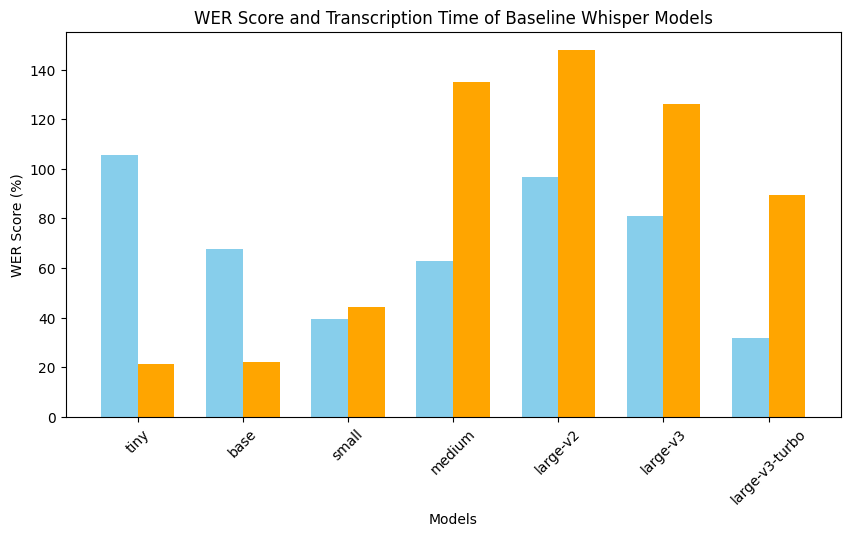

<Figure size 640x480 with 0 Axes>

In [14]:
# plot the dataframe with the results

plt.subplots(figsize=(10, 5))

# Create an array of indices for the x-axis
indices = np.arange(len(results_df['Model']))
bar_width = 0.35

plt.bar(indices, results_df['WER Score (%)'], color='skyblue', label='WER Score', width=bar_width)
plt.bar(indices + bar_width, results_df['Transcription Time (s)'], color='orange', label='Transcription Time', width=bar_width)

# Set the x-ticks to be the model names
plt.xticks(indices + bar_width / 2, results_df['Model'], rotation=45)
plt.xlabel('Models')
plt.ylabel('WER Score (%)')
plt.title('WER Score and Transcription Time of Baseline Whisper Models')
plt.show()
plt.savefig('baseline_models.png')

In [ ]:
# function that returns a dataframe with metrics for each model

def calculate_metrics(reference, predictions):
    results = []    
    for i in range(len(predictions)):
        metrics = jiwer.compute_measures(reference, predictions[i])
        
        # Store the results in a dictionary
        results.append({
            'model': df['Model'][i],
            'wer': metrics['wer'],
            'cer': jiwer.cer(reference, predictions[i]),
            'mer': metrics['mer'],
            'wip': metrics['wip'],
            'wil': metrics['wil'],
            'hits': metrics['hits'],
            'substitutions': metrics['substitutions'],
            'deletions': metrics['deletions'],
            'insertions': metrics['insertions'],
            'total_words_reference': len(reference[0].split()),
            'total_words_predicted': len(predictions[i].split()),
            'diff_amount of words': len(predictions[i].split()) - len(reference[0].split())
        })
        
        # change list to dataframe
        metrics_df = pd.DataFrame(results)
        
    return  metrics_df

In [ ]:
predictions = df['Transcription']

metrics_df = calculate_metrics(reference, predictions)
metrics_df

,model,wer,cer,mer,wip,wil,hits,substitutions,deletions,insertions,total_words_reference,total_words_predicted,diff_amount of words
0,tiny,1.054962,0.526159,0.816785,0.043770,0.956230,155,492,8,191,655,838,183
1,base,0.674809,0.297614,0.613037,0.170995,0.829005,279,350,26,66,655,695,40
2,small,0.395420,0.145021,0.380323,0.418928,0.581072,422,201,32,26,655,649,-6
3,medium,0.625954,0.286599,0.518331,0.286701,0.713299,381,256,18,136,655,773,118
4,large-v2,0.964885,0.834557,0.963415,0.005785,0.994215,24,127,504,1,655,152,-503
5,large-v3,0.810687,0.787288,0.808219,0.146898,0.853102,126,37,492,2,655,165,-490
6,large-v3-turbo,0.316031,0.253786,0.314112,0.610400,0.389600,452,55,148,4,655,511,-144


# Transcription with the Openai Implementation of Whisper and Segment Analysis

In [2]:
import librosa
import whisper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load audio file from P1
file_path = '/run/user/1000/gvfs/sftp:host=lucina.statsbiblioteket.dk,user=anastasia//home/anastasia/lfm/QA/4138467_osri_P1_19960603_0600-0800/4138467_osri_P1_19960603_0600-0800_16k.wav'
audio_data, sampling_rate = librosa.load(file_path, sr=None)

In [ ]:
# loading the model
model_id = 'openai/large-v3-turbo'
model = whisper.load_model(model_id)

In [ ]:
# Output info about the model
model

Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-31): 32 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=1280, out_features=1280, bias=True)
          (key): Linear(in_features=1280, out_features=1280, bias=False)
          (value): Linear(in_features=1280, out_features=1280, bias=True)
          (out): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (attn_ln): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
        (mlp_ln): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_post): LayerNorm(

In [ ]:
# Perform the transcription
result = model.transcribe(audio_data, language='da')

/home/asha/ds_project/ds_project/.conda/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [ ]:
# Create a dataframe with the segments produced by the model
segments = pd.DataFrame(result['segments'])
segments.shape

(761, 11)

In [23]:
segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 761 non-null    int64  
 1   seek               761 non-null    int64  
 2   start              761 non-null    float64
 3   end                761 non-null    float64
 4   text               731 non-null    object 
 5   tokens             761 non-null    object 
 6   temperature        761 non-null    float64
 7   avg_logprob        761 non-null    float64
 8   compression_ratio  761 non-null    float64
 9   no_speech_prob     761 non-null    float64
 10  words              30 non-null     object 
dtypes: float64(6), int64(2), object(3)
memory usage: 65.5+ KB


In [ ]:
segments.head()

,id,seek,start,end,text,tokens,temperature,avg_logprob,compression_ratio,no_speech_prob,words
0,0,0,0.00,1.76,Har nok,"[50365, 3653, 33811, 50453]",1.0,-2.364930,0.466667,3.342737e-10,NaN
1,1,3000,30.00,48.24,"Godmorgen, her er Danmarks Radioprogram 1.","[50365, 1265, 40220, 1766, 11, 720, 1189, 3394...",0.0,-0.397382,0.936508,2.550854e-11,NaN
2,2,3000,49.44,50.60,Klokken er seks.,"[51337, 16053, 453, 2653, 1189, 369, 1694, 13,...",0.0,-0.397382,0.936508,2.550854e-11,NaN
3,3,5060,50.60,76.66,Kogelskab er til synlande slået fejl.,"[50365, 591, 664, 1625, 74, 455, 1189, 8440, 5...",0.0,-0.509883,0.826087,4.080687e-11,NaN
4,4,7666,76.66,82.32,Antallet af sygdomstilfælde er kun faldet meg...,"[50365, 5130, 336, 302, 3238, 943, 70, 4121, 3...",0.0,-0.128926,1.543103,4.657943e-11,NaN


In [26]:
segments.tail()

,id,seek,start,end,text,tokens,temperature,avg_logprob,compression_ratio,no_speech_prob,words
756,756,721376,7213.76,7215.76,Tak fordi du så med.,"[50365, 9118, 47830, 1581, 4719, 1205, 13, 50465]",0.0,-0.14985,0.724138,1.942446e-10,NaN
757,757,721576,7215.76,7245.76,NaN,[],0.0,-0.34828,0.000000,2.079064e-10,[]
758,758,724576,7245.76,7275.76,NaN,[],0.0,-0.41281,0.000000,1.591560e-10,[]
759,759,727576,7275.76,7305.76,NaN,[],0.0,-0.49959,0.000000,1.585556e-10,[]
760,760,730576,7305.76,7320.91,NaN,[],0.0,-0.24633,0.000000,1.673441e-10,[]


In [ ]:
# check for null values in text column i in the dataframe
segments['text'].isnull().sum()

np.int64(30)

Text(0.5, 1.0, 'Segment features')

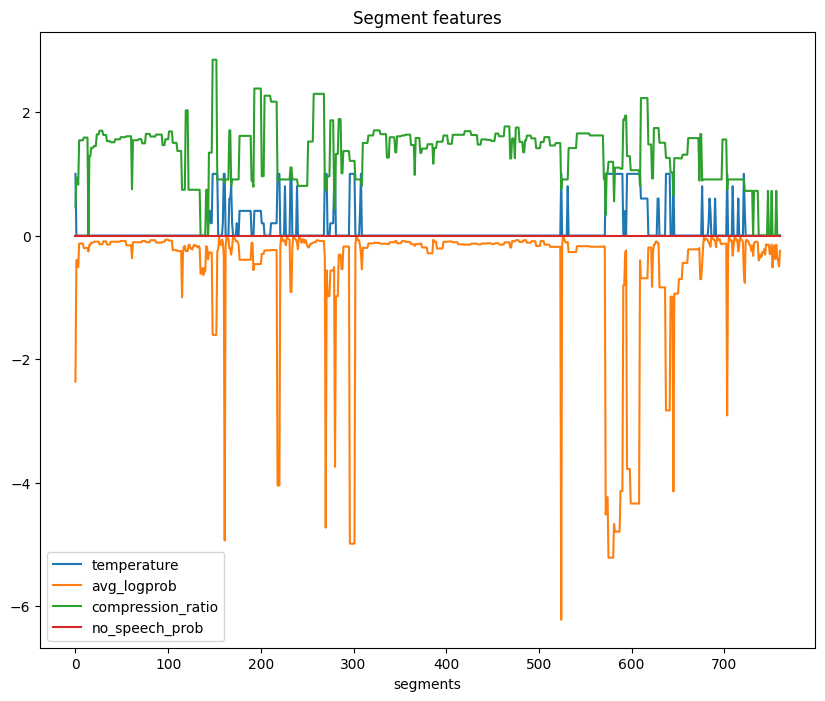

In [ ]:
# plot the temperature, avg_logprob, compression_ratio, no_speech_prob
segments.plot(x="id", xlabel="segments",
        y=["temperature",
           "avg_logprob",
           "compression_ratio",
           "no_speech_prob"],
       figsize=(10, 8))

plt.title('Segment features')

# The no_speech_prob have too small values to be visible in the plot. 
# The plit displays that the when the avg_logprop decreases then the temperature and compression ratio increases. 


Text(0.5, 1.0, 'no_speech_prob')

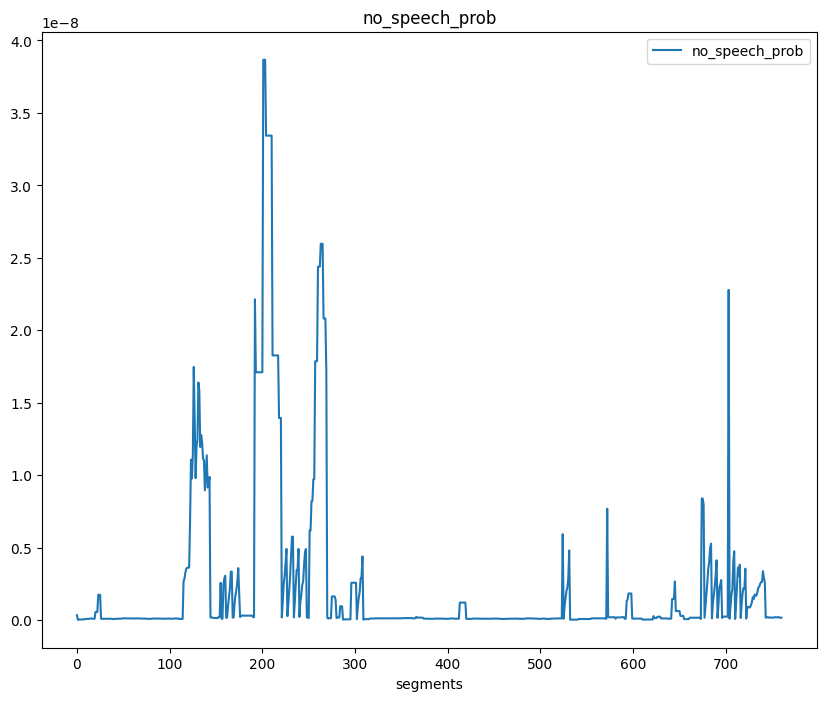

In [ ]:
# plot the no_speech_prob since the values are too small to be visible in the previous plot
segments.plot(x="id", xlabel="segments",
        y=["no_speech_prob"],
       figsize=(10, 8))

plt.title("no_speech_prob")

Text(0.5, 1.0, 'no_speech_prob')

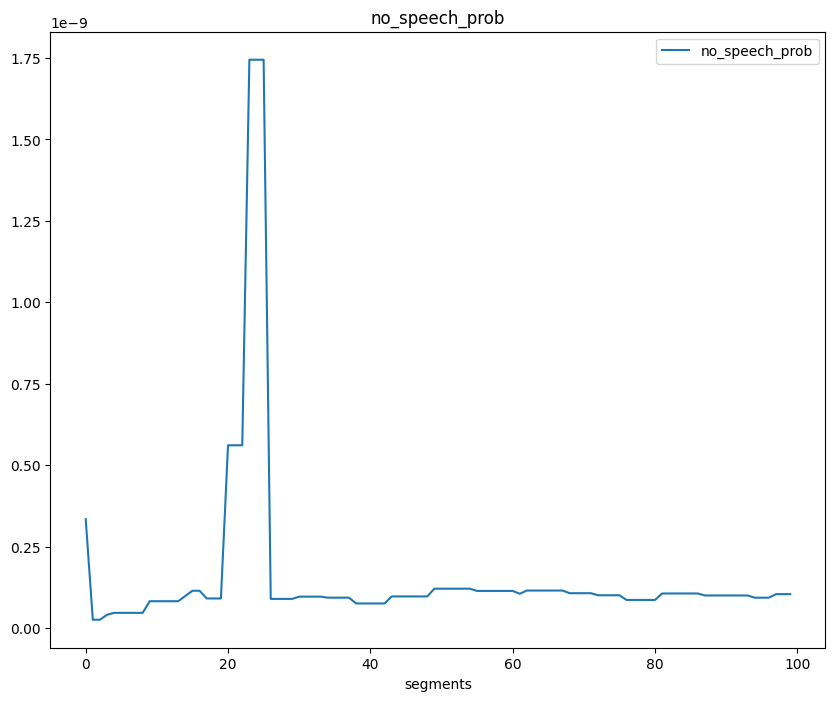

In [18]:
# plot the first 100 segments with no speech probability
segments[:100].plot(x="id", xlabel="segments",
        y=["no_speech_prob"],
       figsize=(10, 8))

plt.title("no_speech_prob")

In [ ]:
# Avg_ loprob is the logaritmic are converted to confidence values for easier interpretation
segments['confidence'] = np.exp(segments['avg_logprob'])
segments[['text', 'confidence']]

,text,confidence
0,Har nok,0.093956
1,"Godmorgen, her er Danmarks Radioprogram 1.",0.672077
2,Klokken er seks.,0.672077
3,Kogelskab er til synlande slået fejl.,0.600566
4,Antallet af sygdomstilfælde er kun faldet meg...,0.879039
...,...,...
756,Tak fordi du så med.,0.860837
757,NaN,0.705901
758,NaN,0.661788
759,NaN,0.606779


In [ ]:
# The dataframe with the confidence values added
segments.head()

,id,seek,start,end,text,tokens,temperature,avg_logprob,compression_ratio,no_speech_prob,words,confidence
0,0,0,0.00,1.76,Har nok,"[50365, 3653, 33811, 50453]",1.0,-2.364930,0.466667,3.342737e-10,NaN,0.093956
1,1,3000,30.00,48.24,"Godmorgen, her er Danmarks Radioprogram 1.","[50365, 1265, 40220, 1766, 11, 720, 1189, 3394...",0.0,-0.397382,0.936508,2.550854e-11,NaN,0.672077
2,2,3000,49.44,50.60,Klokken er seks.,"[51337, 16053, 453, 2653, 1189, 369, 1694, 13,...",0.0,-0.397382,0.936508,2.550854e-11,NaN,0.672077
3,3,5060,50.60,76.66,Kogelskab er til synlande slået fejl.,"[50365, 591, 664, 1625, 74, 455, 1189, 8440, 5...",0.0,-0.509883,0.826087,4.080687e-11,NaN,0.600566
4,4,7666,76.66,82.32,Antallet af sygdomstilfælde er kun faldet meg...,"[50365, 5130, 336, 302, 3238, 943, 70, 4121, 3...",0.0,-0.128926,1.543103,4.657943e-11,NaN,0.879039


In [ ]:
# Save the datafram as a csv file
segments.to_csv('/home/asha/ds_project/csv_files/segments_confidence_P1_19960603_0600-0800.csv', index=False)

#load the csv file as a dataframe
# segments = pd.read_csv('/home/asha/ds_project/csv_files/segments_confidence_P1_19960603_0600-0800.csv')

In [34]:
segments.describe()

,id,seek,start,end,temperature,avg_logprob,compression_ratio,no_speech_prob,confidence
count,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,7.610000e+02,761.000000
mean,380.000000,332714.262812,3334.704494,3343.817201,0.127989,-0.513286,1.354993,2.280191e-09,0.761287
std,219.826068,188089.683118,1880.586695,1882.278914,0.304644,1.097525,0.484424,5.825261e-09,0.245418
min,0.000000,0.000000,0.000000,1.760000,0.000000,-6.220072,0.000000,2.499132e-11,0.001989
25%,190.000000,179974.000000,1799.740000,1801.120000,0.000000,-0.267230,0.909091,9.707468e-11,0.765497
50%,380.000000,365294.000000,3652.940000,3654.940000,0.000000,-0.150843,1.501859,1.208231e-10,0.859983
75%,570.000000,467388.000000,4673.880000,4676.100000,0.000000,-0.107049,1.621212,1.224737e-09,0.898482
max,760.000000,730576.000000,7305.760000,7320.910000,1.000000,-0.008044,2.847826,3.867300e-08,0.991988


In [36]:
# choose a subset of the data for a correlation matrix
segments_subset = segments[['temperature', 'confidence', 'compression_ratio', 'no_speech_prob']]
correlation_matrix = segments_subset.corr(numeric_only=True, method='pearson')
correlation_matrix

,temperature,confidence,compression_ratio,no_speech_prob
temperature,1.000000,-0.809953,-0.056088,0.055278
confidence,-0.809953,1.000000,0.124568,-0.026416
compression_ratio,-0.056088,0.124568,1.000000,0.125069
no_speech_prob,0.055278,-0.026416,0.125069,1.000000


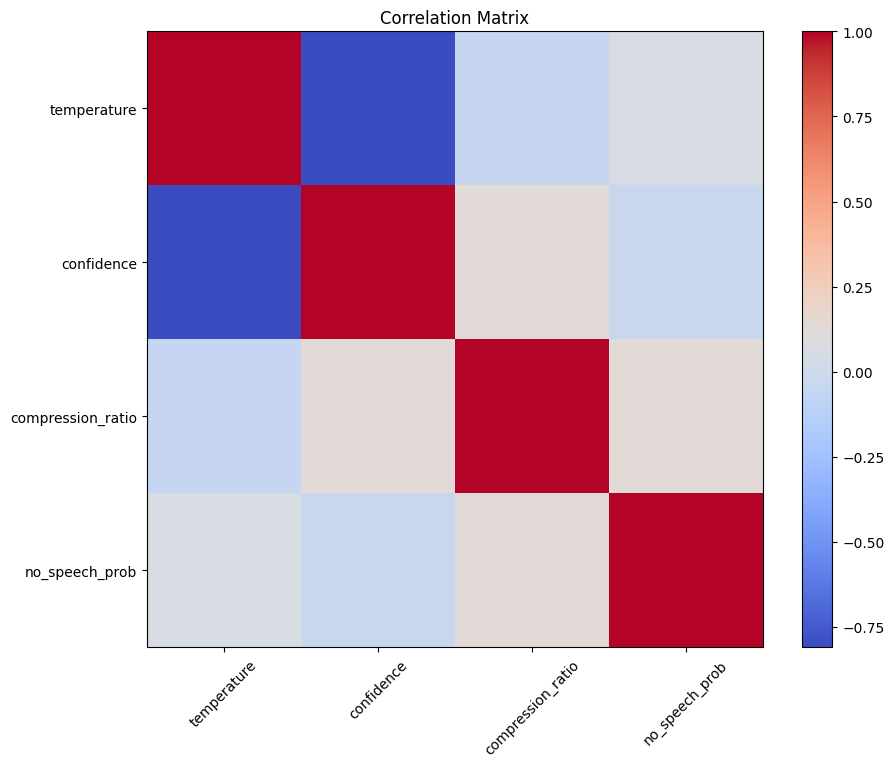

In [ ]:
# Plot et heatmap
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.xticks(rotation=45)
plt.show()

# Negative correlation between temperature and confidence. Lower temperature means that whisper is more deterministic and thus more certain in its predictions.
# Slight negative correlation between temperature and compression_ratio indicating that low temperature (deterministic) means higher compression_ratio.
# The more deterministic the model is, the better it is at compressing the data

Text(0.5, 1.0, 'Confidence and temperature for each segment')

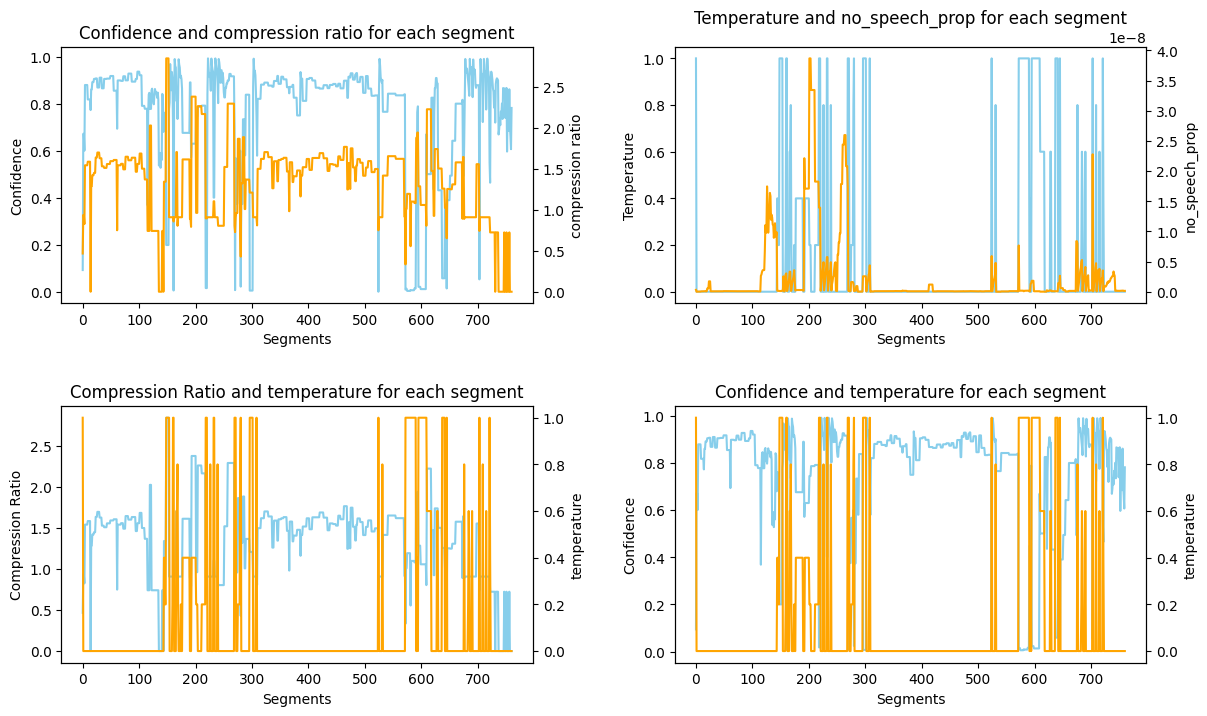

In [29]:
# Create four ax plots for the confidence and no_speech_prob

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3) 


# plot the confidence on the first y-axis and no_speech_prob on the second y-axis
axs[0,0].plot(segments['id'], segments['confidence'], color='skyblue')
axs[0,0].set_xlabel('Segments')
axs[0,0].set_ylabel('Confidence')
axs[0,0]= axs[0,0].twinx()
axs[0,0].plot(segments['id'], segments['compression_ratio'], color='orange')
axs[0,0].set_ylabel('compression ratio')
axs[0,0].set_title('Confidence and compression ratio for each segment')

# plot the temperature on the first y-axis and no_speech_prob on the second y-axis
axs[0,1].plot(segments['id'], segments['temperature'], color='skyblue')
axs[0,1].set_xlabel('Segments')
axs[0,1].set_ylabel('Temperature')
axs[0,1]= axs[0,1].twinx()
axs[0,1].plot(segments['id'], segments['no_speech_prob'], color='orange')
axs[0,1].set_ylabel('no_speech_prop')
axs[0,1].set_title('Temperature and no_speech_prop for each segment')

# plot the compression_ratio on the first y-axis and temperature on the second y-axis
axs[1,0].plot(segments['id'], segments['compression_ratio'], color='skyblue')
axs[1,0].set_xlabel('Segments')
axs[1,0].set_ylabel('Compression Ratio')
axs[1,0]= axs[1,0].twinx()
axs[1,0].plot(segments['id'], segments['temperature'], color='orange')
axs[1,0].set_ylabel('temperature')
axs[1,0].set_title('Compression Ratio and temperature for each segment')

# plot the confidence on the first y-axis and temperature on the second y-axis
axs[1,1].plot(segments['id'], segments['confidence'], color='skyblue')
axs[1,1].set_xlabel('Segments')
axs[1,1].set_ylabel('Confidence')
axs[1,1]= axs[1,1].twinx()
axs[1,1].plot(segments['id'], segments['temperature'], color='orange')
axs[1,1].set_ylabel('temperature')
axs[1,1].set_title('Confidence and temperature for each segment')

In [ ]:
# Extract the text column from the segment file and save it as a txt file to be used for calculating the wer score 
text = segments['text'].tolist()

# convert to a string
text_str = " ".join(str(x) for x in text)
print(type(text_str))
print(len(text_str))

# save text to txt file for testing purposes
with open("transcription_P1_19960603_0600-0800_openai_large_v3_turbo.txt", "w") as f:
    f.write(text_str)

<class 'str'>
43179


# Transcription with Whisper-Large-v3-turbo Hugging Face Implementation

In [ ]:
import numpy as np
import pandas as pd
import torch
import librosa
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
import torch._dynamo
import whisper

In [ ]:
# loading the audio file P! with librosa
file_path = '/run/user/1000/gvfs/sftp:host=lucina.statsbiblioteket.dk,user=anastasia//home/anastasia/lfm/QA/4138467_osri_P1_19960603_0600-0800/4138467_osri_P1_19960603_0600-0800_16k.wav'
audio_data, sampling_rate = librosa.load(file_path, sr=None)

In [ ]:
# Inspecting the audio array
print(audio_data[40000:40020])
print("Sample Rate:", sampling_rate)
print("Number of samples:", len(audio_data))
print("Duration:", len(audio_data) / sampling_rate, "seconds")
print("Duration in hours:", len(audio_data) / sampling_rate / 3600, "hours")
print("Data type:", audio_data.dtype)
print("Shape:", audio_data.shape)

[-1.2207031e-04  1.2207031e-04  4.2724609e-04  6.4086914e-04
  7.6293945e-04  1.0375977e-03  1.2512207e-03  1.4953613e-03
  1.4648438e-03  1.4343262e-03  1.3732910e-03  1.2207031e-03
  9.4604492e-04  7.0190430e-04  4.5776367e-04  9.1552734e-05
 -2.1362305e-04 -3.0517578e-04 -3.9672852e-04 -7.0190430e-04]
Sample Rate: 16000
Number of samples: 117134677
Duration: 7320.9173125 seconds
Duration in hours: 2.033588142361111 hours
Data type: float32
Shape: (117134677,)


In [5]:
type(audio_data)

numpy.ndarray

In [6]:
model = whisper.load_model("large-v3-turbo")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is multilingual and has 806,958,080 parameters.


In [ ]:
# Check if GPU is aviailable else CPU and load the model and pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3-turbo"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True,
)
model.to(device)   # models is moved to the device (GPU or CPU)

processor = AutoProcessor.from_pretrained(model_id)
#model.generation_config.use_cache=False # disable cache for faster decoding
# 

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    chunk_length_s=30,
    batch_size=16,  # batch size for inference - set based on your device
    torch_dtype=torch_dtype,
    device=device,
    return_timestamps=True,
)

In [12]:
# Perform the ASR
transcription = pipe(audio_data)

In [ ]:
# save the transcription to a file
with open("transcription_P1_19960603_0600-0800_large_v3_turbo.txt", "w") as f:
    f.write(transcription["text"])

In [ ]:
# Extract timestamps and texts
timestamps = [entry['timestamp'] for entry in transcription['chunks']]
texts = [entry['text'] for entry in transcription['chunks']]

# Create a new dictionary
new_dict = {
    'timestamps': timestamps,
    'texts': texts
}

df = pd.DataFrame(new_dict)

# Extract the first value from the 'timestamp' column and create a new column 'start time'
df['start_time'] = df['timestamps'].apply(lambda x: x[0])
df['end_time'] = df['timestamps'].apply(lambda x: x[1])

In [ ]:
# save dataframe to csv file
df.to_csv("transcription_P1_19960603_0600-0800_large_v3_turbo.csv", index=False)

# open csv file as dataframe
#df = pd.read_csv("/home/asha/ds_project/csv_files/transcription_P1_19960603_0600-0800_large_v3_turbo.csv")
df.head()

,timestamps,texts,start_time,end_time
0,"(0.0, 48.24)",I don't know. Danske tekster af Jesper Buhl S...,0.00,48.24
1,"(49.26, 65.98)",Klokken er seks. da den 3. juni. Den tyske na...,49.26,65.98
2,"(66.02, 70.84)",der opfylder Maastricht-kriterierne for at væ...,66.02,70.84
3,"(72.18, 76.64)",De britiske myndigheders bestræbelser for at ...,72.18,76.64
4,"(77.08, 79.58)",Antallet af sygdomstilfælde er kun faldet meg...,77.08,79.58


# Fine-tuning of the large-v3-turbo model <br>
The following code piece were run in google colab on GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


Fri Nov  1 13:58:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from datasets import DatasetDict, Audio
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import evaluate
import os
import pandas as pd

from transformers import WhisperForConditionalGeneration, WhisperProcessor
from transformers import WhisperFeatureExtractor, WhisperTokenizer
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import AutoModelForSpeechSeq2Seq, pipeline

from peft import LoraConfig, LoraConfig, get_peft_model

In [ ]:
# load the dataset_dict
dataset_dict = DatasetDict.load_from_disk('/content/drive/MyDrive/colab/radio_dataset/dataset_dict.tsv')
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['audio', 'start', 'end', 'text'],
        num_rows: 20
    })
    val: Dataset({
        features: ['audio', 'start', 'end', 'text'],
        num_rows: 13
    })
})

In [ ]:
# access the first sample in the dataset
sample = dataset_dict['train'][0]
sample

{'audio': 'chunk_0.wav',
 'start': 69.0,
 'end': 91.01,
 'text': 'Danske officeraspiranter udsættes i løbet af deres uddannelse for så hårde afhøringsmetoder, at de kan have svært ved at finde ud af om de må bruge de samme metoder under virkelige fangerafhøringer, skriver Berlingske Tidende. Jeg er bange for, at tingene flyder sammen, så aspiranterne ikke kan skille træning og virkelig fra hinanden'}

In [ ]:
# Update the path to the audio files in the dataset_dict
def update_audio_path(example, data_root="/content/drive/MyDrive/colab/radio_dataset/audio_chunks"):
    """Updates the 'audio' path to the correct location."""
    example["audio"] = os.path.join(data_root, example["audio"])
    return example

dataset_dict = dataset_dict.map(update_audio_path)

In [ ]:
# access the first sample in the dataset
sample = dataset_dict['train'][0]
sample

{'audio': '/content/drive/MyDrive/colab/radio_dataset/audio_chunks/chunk_0.wav',
 'start': 69.0,
 'end': 91.01,
 'text': 'Danske officeraspiranter udsættes i løbet af deres uddannelse for så hårde afhøringsmetoder, at de kan have svært ved at finde ud af om de må bruge de samme metoder under virkelige fangerafhøringer, skriver Berlingske Tidende. Jeg er bange for, at tingene flyder sammen, så aspiranterne ikke kan skille træning og virkelig fra hinanden'}

In [ ]:
# load the first audio chunk for inspection
file_path = '/content/drive/MyDrive/colab/radio_dataset/audio_chunks/chunk_0.wav'
audio_1_chunk, sampling_rate = librosa.load(file_path, sr=None)

In [ ]:
# Inspecting the audio data
print(audio_1_chunk)
print("Sample Rate:", sampling_rate)
print("Number of samples:", len(audio_1_chunk))
print("Duration:", len(audio_1_chunk) / sampling_rate, "seconds")
print("Duration in hours:", len(audio_1_chunk) / sampling_rate / 3600, "hours")
print("Data type:", audio_1_chunk.dtype)
print("Shape:", audio_1_chunk.shape)

[-0.043396   -0.04190063 -0.03707886 ...  0.01422119  0.01419067
  0.01446533]
Sample Rate: 16000
Number of samples: 352160
Duration: 22.01 seconds
Duration in hours: 0.006113888888888889 hours
Data type: float32
Shape: (352160,)


In [ ]:
model_name_or_path = "openai/whisper-large-v3-turbo"
language = "Danish"
language_abbr = "da"
task = "transcribe"

In [ ]:
# load the feature extractor
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path,language=language,task=task)

In [ ]:
# load the tokenizer
tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path,language=language,task=task)

In [ ]:
# load the processor
processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)

In [ ]:
type(dataset_dict)

datasets.dataset_dict.DatasetDict

In [ ]:
# function to process the dataset
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        audio=audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=example["text"],
    )

    return example

In [ ]:
dataset_dict["train"].features

{'audio': Value(dtype='string', id=None),
 'start': Value(dtype='float64', id=None),
 'end': Value(dtype='float64', id=None),
 'text': Value(dtype='string', id=None)}

In [ ]:
# process the audio data from the dataset_dict
sampling_rate = processor.feature_extractor.sampling_rate
dataset_dict = dataset_dict.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [ ]:
dataset_dict["train"].features

{'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'start': Value(dtype='float64', id=None),
 'end': Value(dtype='float64', id=None),
 'text': Value(dtype='string', id=None)}

In [ ]:
dataset = dataset_dict.map(
    prepare_dataset, remove_columns=dataset_dict.column_names["train"], num_proc=1
)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 20
    })
    val: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 13
    })
})

In [ ]:
# Define the data collator that pads the audio features and tokenized labels

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
# initialize the data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [ ]:
# evaluation metrics
metric = evaluate.load("wer")

In [ ]:
# A function that computes the WER metric

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    #label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
# load the model with pretrained checkpoint
model = WhisperForConditionalGeneration.from_pretrained(model_name_or_path)

In [ ]:
model.config.forced_decoder_ids = None # set to none to force the model to predict the correct language
model.config.suppress_tokens = []  # No tokens should be suppressed


In [ ]:
# Load a LoRA adapter
config = LoraConfig(r=32,
                    lora_alpha=64,
                    target_modules=["q_proj", "v_proj"], # target_modules angiver hvilke specifikke dele af netværket der vil blive konfigureret med LoRa-parametrene (Query og Value fra attention-mekanismen)
                    lora_dropout=0.05,
                    bias="none")

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 6,553,600 || all params: 815,431,680 || trainable%: 0.8037


In [ ]:
# Set the model_path for saving the fine-tuned model and configure the training arguments
model_path = "/content/drive/MyDrive/colab/whisper_fine_tuned_large_v3-turbo"

training_args = Seq2SeqTrainingArguments(
    output_dir=model_path, 
    per_device_train_batch_size=3, 
    gradient_accumulation_steps=1,  
    learning_rate=1e-3,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    fp16=True, #True mwith GPU access
    per_device_eval_batch_size=1,
    generation_max_length=128,
    logging_steps=1,
    remove_unused_columns=False,
    label_names=["labels"],
    predict_with_generate=True, 
    save_steps=0.2, 
)

In [ ]:
# Instantiate the Seq2SeqTrainer and disable cache to increase speed
# results logged in wandb interface
 
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)
model.config.use_cache = False

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: adatamahan (adatamahan-ec-utbildning). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Wer
1,1.478400,1.563958,37.234043
2,0.529500,1.110326,34.042553
3,0.155100,1.099420,42.553191
4,0.078200,1.116672,32.978723
5,0.009800,1.110293,40.425532


TrainOutput(global_step=35, training_loss=0.41309738575613925, metrics={'train_runtime': 123.0006, 'train_samples_per_second': 0.813, 'train_steps_per_second': 0.285, 'total_flos': 1.72005064704e+17, 'train_loss': 0.41309738575613925, 'epoch': 5.0})

In [ ]:
# the best model is in epoch 28
best_model_path = "/content/drive/MyDrive/colab/fine_tuned_large_v3-turbo/checkpoint-28"

model.save_pretrained(best_model_path)

[]


# Transcribing with the Fine-Tuned Large-v3-turbo model


In [ ]:
# check GPU access and load the best model

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    best_model_path, torch_dtype=torch_dtype, low_cpu_mem_usage=True,
)
model.to(device)

# The model information shows the LoRA layers that have been fine-tuned and incorporated into the base model

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): lora.Linear(
              (base_layer): Linear(in_features=1280, out_features=1280, bias=True)
              (lora_dropout): ModuleDict(
                (default): Dropout(p=0.05, inplace=False)
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=1280, out_features=32, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=32, out_features=1280, bias=False)
              )
              

In [ ]:
# Loading the processor from the basemodel
processor_path = '/content/drive/MyDrive/colab/fine_tuned_large_v3-turbo'
processor = WhisperProcessor.from_pretrained(processor_path)

In [ ]:
pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    chunk_length_s=30,
    batch_size=16,  
    torch_dtype=torch_dtype,
    device=device,
    return_timestamps=True,
)

In [ ]:
# upload the P1 audio file for transcription
file_path = '/content/drive/MyDrive/colab/4138467_osri_P1_19960603_0600-0800_16k.wav'
audio_data, sampling_rate = librosa.load(file_path, sr=None)

In [ ]:
# Perform the ASR
transcription_pretrained_P1_19960603_0600_0800 = pipe(audio_data, return_timestamps=True, generate_kwargs={"language": "danish", "task": "transcribe"})

In [ ]:
transcription_pretrained_P1_19960603_0600_0800.keys()

dict_keys(['text', 'chunks'])

In [ ]:
# save the transcription to a file
with open("/content/drive/MyDrive/colab/transcription__pretrained_P1_19960603_0600-0800_large_v3_turbo.txt", "w") as f:
    f.write(transcription_pretrained_P1_19960603_0600_0800["text"])

In [ ]:
# Extract timestamps and texts
timestamps = [entry['timestamp'] for entry in transcription_pretrained_P1_19960603_0600_0800['chunks']]
texts = [entry['text'] for entry in transcription_pretrained_P1_19960603_0600_0800['chunks']]

# Create a new dictionary
new_dict = {
    'timestamps': timestamps,
    'texts': texts
}

df = pd.DataFrame(new_dict)
df.head()

,timestamps,texts
0,"(0.0, 48.22)","Hvad har nøng tænd? Godmorgen, her er Danmark..."
1,"(49.36, 50.62)",Klokken er seks.
2,"(58.0, 61.22)","Godmorgen, her er Radioavisen. Det er mandag ..."
3,"(62.32, 70.86)","Den tyske Nationalbank er imod, at Danmark bl..."
4,"(72.0, 76.64)",De britiske myndigheders bestræbelser for et ...


In [ ]:
# Extract the first value from the 'timestamp' column and create a new column 'start time'
df['start_time'] = df['timestamps'].apply(lambda x: x[0])
df['end_time'] = df['timestamps'].apply(lambda x: x[1])
df.head()

,timestamps,texts,start_time,end_time
0,"(0.0, 48.22)","Hvad har nøng tænd? Godmorgen, her er Danmark...",0.00,48.22
1,"(49.36, 50.62)",Klokken er seks.,49.36,50.62
2,"(58.0, 61.22)","Godmorgen, her er Radioavisen. Det er mandag ...",58.00,61.22
3,"(62.32, 70.86)","Den tyske Nationalbank er imod, at Danmark bl...",62.32,70.86
4,"(72.0, 76.64)",De britiske myndigheders bestræbelser for et ...,72.00,76.64


In [ ]:
# save dataframe to csv file
df.to_csv("/content/drive/MyDrive/colab/transcription_P1_19960603_0600-0800_pretrained_large_v3_turbo.csv", index=False)

# Transcribing with a Pretrained Whisper Medium Model trained on Commonvoice 11 dataset

In [ ]:
import numpy as np
import pandas as pd
import torch
import librosa
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
import torch._dynamo

In [ ]:
# model from https://huggingface.co/WasuratS/whisper-small-da

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "WasuratS/whisper-small-da"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True,
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    chunk_length_s=30,
    batch_size=16,
    torch_dtype=torch_dtype,
    device=device,
)

In [ ]:
# load audio file from P1
file_path = '/content/drive/MyDrive/colab/4138467_osri_P1_19960603_0600-0800_16k.wav'
audio_data, sampling_rate = librosa.load(file_path, sr=None)

In [ ]:
transcription_pretrained = pipe(audio_data)

In [ ]:
# save as txt file
with open("predictions_P1_19960603_0600_0800_WasuratS_whisper_small_da.txt", "w") as f:
    f.write(transcription_pretrained["text"])

# Evaluation of the Models

In [10]:
import pandas as pd
import jiwer
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

In [11]:
# create a function that returns the WER for a given reference and prediction text
   
def calculate_wer(prediction, reference, model):
    # A function that calculates evaluation metrics and returns a pandas dataframe
    metrics = {}
    model = model
    
    # Calculate jiwer metrics
    metrics = jiwer.compute_measures(prediction, reference)
    wer = metrics['wer']
    substitutions = metrics['substitutions']
    deletions = metrics['deletions']
    insertions = metrics['insertions']
    
    # Initialize the normalizer 
    normalizer = BasicTextNormalizer()
    
    normalized_prediction = normalizer(prediction)
    normalized_reference = normalizer(reference)
    
    wer_norm = jiwer.wer(normalized_prediction, normalized_reference)
    
    # Colelcted the metrics in a dictionary
    metrics = {'model': model,
               'wer': wer, 
               'wer_norm': wer_norm, 
               'substitutions': substitutions, 
               'deletions': deletions, 
               'insertions': insertions}
    
    # convert dict to pd series and return as one row dataframe
    metrics = pd.Series(metrics, index=metrics.keys()).to_frame().T
    
    return metrics


In [12]:
# A function that iterates over lists of predictions, references, and models, calculates the WER, returning a DataFrame with the results

def calcualte_metrics(prediction_list, reference, model_list):
    results = []
    reference = reference
    
    # Ensure all lists are of the same length
    if not (len(prediction_list) == len(model_list)):
        raise ValueError("All input lists must have the same length.")
    
    # Iterate over the lists and convert to strings
    for prediction, model in zip(prediction_list, model_list):
        prediction = str(prediction)
        reference = str(reference)
        
        metrics = calculate_wer(prediction, reference, model)
        results.append(metrics)
        
    final_results_df = pd.concat(results, ignore_index=True)
    
    return final_results_df

In [ ]:
# load the txt files with the transcriptions
with open("/home/asha/ds_project/transcripts/predictions_P1_19960603_0600_0800_openai_large_v3_turbo.txt", "r") as f:
    predictions_P1_19960603_0600_0800_openai_large_v3_turbo = f.read()
    
with open("/home/asha/ds_project/transcripts/predictions_P1_19960603_0600_0800_hf_large_v3_turbo.txt", "r") as f:
    predictions_P1_19960603_0600_0800_hf_large_v3_turbo = f.read()

with open("/home/asha/ds_project/transcripts/predictions_P1_19960603_0600_0800_finetuned_large_v3_turbo.txt", "r") as f:
    predictions_P1_19960603_0600_0800_finetuned_large_v3_turbo = f.read()

with open("/home/asha/ds_project/transcripts/predictions_P1_19960603_0600_0800_WasuratS_whisper_small_da.txt", "r") as f:
    predictions_P1_19960603_0600_0800_WasuratS_whisper_small_da = f.read()

# load the reference text
with open("texts/text_P1_19960603_0600-0800.txt", "r") as f:
    reference_P1 = f.read()

In [19]:
# create a prediction list and a reference list
prediction_list = [
                predictions_P1_19960603_0600_0800_openai_large_v3_turbo,
                predictions_P1_19960603_0600_0800_hf_large_v3_turbo, 
                predictions_P1_19960603_0600_0800_finetuned_large_v3_turbo,
                predictions_P1_19960603_0600_0800_WasuratS_whisper_small_da
                ]
#reference_list = [reference_P1, reference_P1, reference_P1, reference_P1]
model_list = [
                'openai-large-v3-turbo', 
                'hf-large-v3-turbo', 
                'fine-tuned-large-v3-turbo', 
                'WasuratS_whisper_small_da'
                ]

In [20]:
metric_df =  calcualte_metrics(prediction_list, reference_P1, model_list)
metric_df

,model,wer,wer_norm,substitutions,deletions,insertions
0,openai-large-v3-turbo,0.456281,0.432879,1981,765,505
1,hf-large-v3-turbo,0.226488,0.200717,635,834,224
2,fine-tuned-large-v3-turbo,0.427976,0.403128,859,2993,257
3,WasuratS_whisper_small_da,0.851353,0.813139,3772,4365,769
